In [ ]:
sc.install_pypi_package("boto3") 

ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
1,application_1654142079478_0002,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/ce/3d/dc2fedf59cac4c7bd60362ccea1c1b299bb7952a9c2d563a7277a0c69e93/boto3-1.24.1-py3-none-any.whl

In [3]:
import boto3

from sparknlp.annotator import *
from sparknlp.base import *
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from pyspark.sql.types import (StructType, StructField, StringType, DateType)
from pyspark.ml import Pipeline
from pyspark.ml.feature import (CountVectorizer, RegexTokenizer,IDF, StopWordsRemover)
from pyspark.ml.clustering import LDA


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Review the dataset
The import of data here is for displaying. Dataset for each year and decades will be imported later.

In [83]:
data = spark.read.csv('s3://large-scale-computing-lyrics/lyrics_clean.csv', 
                      header=True, 
                      sep=',', 
                      escape="\"", 
                      multiLine=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [84]:
data.show()
data.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+----+--------------------+--------------------+--------------------+
|_c0|Year|              Artist|           Song Name|              Lyrics|
+---+----+--------------------+--------------------+--------------------+
|  0|1958|Boots Brown And H...|             Cerveza|Cerveza LyricsIns...|
|  1|1958|           Doris Day|      Tunnel Of Love|Tunnel Of Love Ly...|
|  2|1958|      Billy & Lillie|       Lucky Ladybug|Lucky Ladybug Lyr...|
|  3|1958|         Nappy Brown|It Don't Hurt No ...|Damn Lyrics
Ohhhh...|
|  4|1958|           Cozy Cole|             Topsy I|NAGASAKI LyricsHo...|
|  5|1958|      The Four Coins|   The World Outside|Angel Station Lyr...|
|  6|1958|       Frank Sinatra|         Mr. Success|Mr. Success Lyric...|
|  7|1958|     The Rinky-Dinks|Early In The Morning|Early In The Morn...|
|  8|1958|Tommy Sands And T...|   The Worryin' Kind|The Worryin’ Kind...|
|  9|1958|         Bobby Helms|The Fool And The ...|The Fool And The ...|
| 10|1958|Perez Prado And H...|       

### Extract words in lyrics

In [13]:

def set_document_assembler(inputCol):
    '''Document assembler'''
    return DocumentAssembler().setInputCol(inputCol)


def set_tokenizer(inputCol, outputCol):
    '''Tokenize words'''
    tokenizer = (Tokenizer()
        .setInputCols([inputCol])
        .setOutputCol(outputCol)
    )
    return tokenizer


def set_lemmatizer(inputCol, outputCol):
    '''Set root lemmas for tokens'''
    lemmatizer = (LemmatizerModel.pretrained(name="lemma_antbnc", lang="en")
        .setInputCols([inputCol])
        .setOutputCol(outputCol)
    )
    return lemmatizer

def set_finisher(finishedCol):
    '''Transform the words using finisher'''
    finisher = (Finisher()
        .setInputCols([finishedCol])
        .setIncludeMetadata(False)
    )
    return finisher

    
def nlp_lyrics(data):
    '''
    Deal with the data of lyrics using NLP pipeline consisting of the above steps
    Input: the dataset read from csv
    Output: dataframe with tokens
    '''
    
    # Remove stop words in text
    STOP_WORDS =["i'm", "don't", "like", 'lyrics','lyric','too', 'hence', 'give', 'never', 'without', "'m", 'something', "'s", 'well', 'hers', 'nine', 'off', 'noone', 'used', 'onto', 'to', 'much', 'us', 'via', 'less', 'had', 'anyone', 'neither', 'an', 'full', 'then', 'twenty', 'thereby', 'keep', 'yourself', 'thus', 'using', 'yourselves', 'each', 'which', 'how', 'doing', '’re', 'whereby', 'with', 'somewhere', 'name', 'that', 'otherwise', 'of', 'around', 'about', 'side', 'sometime', 'back', 'become', 'thru', 'ca', 'becoming', 'formerly', 'empty', 'not', 'often', 'such', 'very', 'therein', 'among', 'here', 'other', 'below', 'again', 'either', 'we', 'what', '’d', 'hereafter', 'ours', 'fifty', 'ourselves', 'your', 'front', 'by', 'upon', 'myself', 'or', 're', 'two', 'thence', 'hundred', 'anywhere', 'make', 'toward', 'towards', 'might', 'thereupon', 'should', 'forty', 'everything', 'me', 'unless', 'nevertheless', 'anyhow', 'former', 'behind', 'always', 'before', 'except', '‘ll', 'wherever', 'nowhere', 'first', 'do', 'move', 'any', 'say', 'been', 'who', 'at', 'also', 'themselves', 'somehow', 'can', 'will', '’s', 'wherein', 'least', 'namely', 'in', 'meanwhile', 'beyond', 'alone', 'moreover', 'and', 'due', 'himself', 'where', 'does', 'she', 'must', 'just', 'hereupon', 'herself', 'n‘t', 'being', 'under', "n't", 'why', 'another', 'during', 'his', 'no', "'ll", '’ve', 'everywhere', 'latterly', 'them', 'seems', 'would', 'next', 'this', 'put', 'third', 'made', 'together', 'as', 'enough', 'but', 'whole', 'you', 'rather', 'our', 'call', 'some', 'between', 'every', 'the', 'everyone', 'their', 'were', 'please', 'six', 'whose', 'perhaps', 'up', 'done', 'whom', 'thereafter', '‘ve', 'indeed', '‘s', 'twelve', '’m', 'sometimes', 'is', 'becomes', 'its', 'may', 'down', 'seemed', 'all', 'many', 'further', 'though', 'through', 'eight', 'are', 'became', 'they', 'yet', 'whither', 'against', 'cannot', 'bottom', 'whereafter', 'none', 'only', 'latter', 'since', 'else', 'was', 'more', 'various', 'serious', 'sixty', "'re", 'take', 'part', 'beside', 'most', 'ever', 'he', 'out', 'over', 'my', 'quite', 'however', "'d", 'because', 'already', 'on', 'four', 'nothing', 'n’t', 'whereas', 'has', 'once', 'top', 'seeming', 'within', 'regarding', 'almost', 'afterwards', 'both', 'per', 'several', 'seem', 'am', 'see', 'whatever', 'did', 'five', 'ten', 'yours', 'really', 'a', 'anything', '‘re', 'mine', 'still', 'elsewhere', 'whence', 'from', 'nor', 'him', 'last', 'her', 'while', 'hereby', 'eleven', 'itself', 'same', 'have', 'across', 'these', 'above', 'so', '‘m', 'therefore', 'than', "'ve", 'others', 'whenever', 'few', 'one', 'into', '‘d', 'get', 'amongst', 'if', 'anyway', 'whether', 'three', 'for', 'fifteen', 'after', 'nobody', 'amount', 'whereupon', 'whoever', 'could', 'it', 'when', 'someone', 'mostly', 'besides', 'although', 'now', 'go', 'until', 'i', 'own', 'herein', 'be', '’ll', 'show', 'throughout', 'even', 'there', 'beforehand', 'those', 'along']
    
    remover = (StopWordsRemover(
               inputCol="finished_lemma", outputCol="words_cleaned")
               .setStopWords(STOP_WORDS))
    
    # Construct nlp pipeline 
    nlp_pipeline = Pipeline(stages=[
        set_document_assembler("further_clean_text"),
        set_tokenizer("document", "token"),
        set_lemmatizer("token", "lemma"),
        set_finisher("lemma"),
        remover
    ])
    
    # Remove special characters
    regex = r"[\!\(\)\-\[\]\{\}\;\:\'\"\\\,\<\>\.\/\?\@\#\$\%\^\&\*\_\~\']"
    df = data.withColumn('further_clean_text',f.regexp_replace('further_clean_text', regex, '')) \
                         .withColumn('further_clean_text',f.regexp_replace('further_clean_text', r"\n", ' ')) \
                         .withColumn('further_clean_text',f.regexp_replace('further_clean_text', r" i ", '')) \
                         .withColumn('further_clean_text',f.regexp_replace('further_clean_text', r" it ", ''))
    
    # Take action to fit the pipeline to data
    token_df = (nlp_pipeline.fit(df)
        .transform(df)
        .withColumnRenamed('words_cleaned', 'lyrics_words')
    )
    
    return token_df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Train LDA Topic Model for lyrics

In [5]:
def get_topics(df):
    
    """
    Get topic words and weights from the LDA model.
    
    Input: the processed dataframe
    Output: topics, shown as a lists.
    """
    
    # Set parameters grid for further usage
    params = dict(
        num_topics = 10,iterations = 10,vocabsize = 5000,
        minDF = 0.02, maxDF = 0.8, minTF = 1)
    
    # Covert tokens into features
    countvectorizer = CountVectorizer(
            inputCol="lyrics_words",
            outputCol="features",
            vocabSize=params['vocabsize'],
            minDF=params['minDF'],
            maxDF=params['maxDF'],
            minTF=params['minTF'])
    
    idf = IDF(inputCol="features", outputCol="idf")

    # Contruct pipeline consisting of countvectorizer and idf
    Pipeline1 = Pipeline(stages=[
                countvectorizer,
                idf])
    # Construct model for Lda topic model
    lda = LDA(
            k=params['num_topics'],
            maxIter=params['iterations'],
            optimizer="online",
            seed=0,
            learningOffset=100.0, 
            learningDecay=0.51,)
    Pipeline2 = Pipeline(stages=[lda])
    
    ml1 = Pipeline1.fit(df)
    ml1_df = ml1.transform(df)
    ml2 = Pipeline2.fit(ml1_df)

    # Obtain topic model
    vocabulary = ml1.stages[0].vocabulary
    ldaModel = ml2.stages[-1]

    # Extract top 15 words for each topic
    topics = ldaModel.describeTopics(15)
    
    # Convert the DataFrame back into an RDD to use the LDA algorithm,
    rdd = topics.rdd

    rdd_topics = rdd \
        .map(lambda row: row['termIndices']) \
        .map(lambda idx_list: [vocabulary[i] for i in idx_list]) \
        .collect()

    rdd_weights = rdd \
        .map(lambda row: row['termWeights']) \
        .collect()

    # Put results in a list
    topics = [dict(zip(output_words, output_weights))
              for output_words, output_weights in zip(rdd_topics, rdd_weights)]
    return topics

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

-------------

### Get the topic for each year

In [10]:
result_combo = {}
for i in range(1958, 2022):
    if i!=2000:
        word_df = spark.read.csv('s3://large-scale-computing-lyrics/each_year_csv/{}.csv'.format(i), 
                                  header=True, 
                                  sep=',', 
                                  escape="\"", 
                                  multiLine=True)
        result = get_topics(nlp_lyrics(word_df))    
        result_combo[i] = result

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-10:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 1092



lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
lemma_antb

In [11]:
result_combo

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{1958: [{'Body': 0.009140998710141327, 'Time': 0.007873299168357798, 'Love': 0.00731033187446128, 'Baby': 0.006704436852137423, 'Bruce': 0.006613501270490068, 'Long': 0.006585905636742459, 'Instrumental': 0.00566540039809928, 'Springsteen': 0.005296937983550599, 'Way': 0.004885136803576704, 'John': 0.004879779244689752, 'Come': 0.004770899790446495, 'Hear': 0.004657845816612072, 'Free': 0.004583503036139797, 'Ride': 0.004549156709091093, 'Bob': 0.00450145739988534}, {'Jessica': 0.018763556119743556, 'know': 0.015732577673916153, 'Im': 0.013726405722982369, 'tell': 0.008334610528819826, 'phone': 0.00805231156623235, 'want': 0.008038031208369873, 'come': 0.007860156405498708, 'leave': 0.007236383273458599, 'time': 0.006965248892709087, 'gonna': 0.00670010698738812, 'dont': 0.00666493990515892, 'right': 0.006562752077371193, 'cant': 0.006534546386699501, 'Oh': 0.006375863065344233, 'love': 0.006082827904806615}, {'Springsteen': 0.0034676780869847706, 'Love': 0.0033679996403241474, 'Long':

---------

### Get topic for decades

In [14]:
data5868 = spark.read.csv('s3://large-scale-computing-lyrics/decade/1958_1968.csv', 
                      header=True, 
                      sep=',', 
                      escape="\"", 
                      multiLine=True)
topic5868=get_topics(nlp_lyrics(data5868))


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]

In [15]:
data6878 = spark.read.csv('s3://large-scale-computing-lyrics/decade/1968_1978.csv', 
                      header=True, 
                      sep=',', 
                      escape="\"", 
                      multiLine=True)
topic6878=get_topics(nlp_lyrics(data6878))


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]

In [16]:
data7888 = spark.read.csv('s3://large-scale-computing-lyrics/decade/1978_1988.csv', 
                      header=True, 
                      sep=',', 
                      escape="\"", 
                      multiLine=True)
topic7888=get_topics(nlp_lyrics(data7888))


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]

In [17]:
data8898 = spark.read.csv('s3://large-scale-computing-lyrics/decade/1988_1998.csv', 
                      header=True, 
                      sep=',', 
                      escape="\"", 
                      multiLine=True)
topic8898=get_topics(nlp_lyrics(data8898))


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]

In [18]:
data9808 = spark.read.csv('s3://large-scale-computing-lyrics/decade/1998_2008.csv', 
                      header=True, 
                      sep=',', 
                      escape="\"", 
                      multiLine=True)
topic9808=get_topics(nlp_lyrics(data9808))


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]

In [19]:
data0818 = spark.read.csv('s3://large-scale-computing-lyrics/decade/2008_2018.csv', 
                      header=True, 
                      sep=',', 
                      escape="\"", 
                      multiLine=True)
topic0818=get_topics(nlp_lyrics(data0818))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]

In [26]:
print(topic5868)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[{'ooh': 0.05094791576803836, 'oh': 0.04502630939376564, 'sing': 0.03788094342020785, 'baby': 0.034841816403648584, 'know': 0.033456262110862146, 'dance': 0.03315015056190335, 'wanna': 0.029012395062267753, 'maybe': 0.028356013553390676, 'yeah': 0.02305861938903945, 'cause': 0.02060966860115842, 'guess': 0.020351313274548893, 'step': 0.020157263511872806, 'fine': 0.017039081167614947, 'want': 0.015237950876619423, 'gonna': 0.015216262157624876}, {'love': 0.051760747809103544, 'white': 0.04075717617858605, 'dream': 0.030457381058145834, 'sweet': 0.029932105108448383, 'sleep': 0.01939366773973544, 'wish': 0.019036942632769102, 'dear': 0.018593335163723926, 'grow': 0.017298116181921893, 'watch': 0.013909691094848638, 'send': 0.01370691196222729, 'bear': 0.013396273951414827, 'day': 0.012968020642842144, 'sign': 0.012745538523111081, 'lady': 0.011344683398844714, 'god': 0.011310655854080087}, {'come': 0.11770950050913982, 'want': 0.0414028113521569, 'eye': 0.02712669353349771, 'shes': 0.02

In [27]:
print(topic6878)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[{'light': 0.03572782112161607, 'way': 0.03532105928789873, 'look': 0.03481477896347087, 'love': 0.02883638353871456, 'ive': 0.02638027705854467, 'know': 0.025352850325248734, 'life': 0.02441833722262353, 'morning': 0.02091155088074059, 'girl': 0.020894034511005636, 'feel': 0.019683123565890817, 'close': 0.017862393833438656, 'let': 0.016690144883819716, 'day': 0.0157815556561872, 'live': 0.01465805980364141, 'lose': 0.013382093824996333}, {'country': 0.049749937342632625, 'music': 0.03294399113225874, 'blue': 0.019277521564192095, 'black': 0.016981272464368966, '2': 0.016231196737469377, 'carry': 0.013971194353108226, 'play': 0.013286768827612056, 'band': 0.01225978048385397, 'pull': 0.01156095390134516, 'gun': 0.01108206576641142, 'kid': 0.010301201650054196, 'red': 0.010049780220601568, 'blood': 0.009996842434843719, 'mountain': 0.009896708098999613, 'boy': 0.009803783576906297}, {'world': 0.06816042594173118, 'song': 0.04679862975280702, 'people': 0.040068092480180686, 'dance': 0.0

In [28]:
print(topic7888)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[{'little': 0.12229719570300833, 'wait': 0.072814626246229, 'sure': 0.04932006442720522, 'bit': 0.04723166371779721, 'know': 0.04690696679039525, 'id': 0.026782440084257297, 'tear': 0.025820934616641734, 'ill': 0.025261106540010413, 'let': 0.02252801004459257, 'lonely': 0.02183105082776881, 'want': 0.02161669072310443, 'youve': 0.020611524732184857, 'minute': 0.01778554750609752, 'away': 0.017309652128999948, 'low': 0.012245430114413203}, {'oh': 0.21547949611274772, 'blue': 0.06705547464366308, 'time': 0.05255850115062321, 'baby': 0.04658680932697538, 'runnin': 0.034964923965412675, 'aint': 0.023713251918283097, 'arm': 0.02360495494697574, 'magic': 0.02199222186911788, 'feel': 0.0214894203085917, 'hand': 0.015057695767924244, 'darlin': 0.015015676162151048, 'eye': 0.013856715315466794, 'little': 0.012903455517504858, 'shell': 0.012300973410094814, 'far': 0.010623448450568028}, {'love': 0.20802106387576488, 'let': 0.045437973275861875, 'want': 0.043527804755001086, 'know': 0.03235630222

In [29]:
print(topic8898)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[{'la': 0.21561420738755843, 'long': 0.08051177862275827, 'come': 0.07752006434267301, 'soul': 0.027754450778725046, 'cool': 0.025423019077699255, 'love': 0.024845538375984844, 'baby': 0.02303255558243197, 'set': 0.022841547594160683, 'free': 0.021636417681796933, 'groove': 0.020235663480437375, 'sweat': 0.017724176064627947, 'want': 0.016378035521380712, 'think': 0.014640541363254536, 'hit': 0.012243012098189513, 'crazy': 0.010763121733218025}, {'rock': 0.021389540102567727, 'jump': 0.01609420236291012, 'come': 0.015824165818243353, 'flow': 0.014712905926948629, 'good': 0.01456596974950843, 'check': 0.0125181800875604, 'big': 0.012115436925587766, 'hit': 0.010867534032440118, 'yo': 0.010510499487695285, 'hand': 0.009490290567737956, 'let': 0.009440232979508693, 'mic': 0.009317994631147143, 'jam': 0.009130521562357524, 'step': 0.008914205939358688, 'ice': 0.008878628663413874}, {'baby': 0.06822545762191613, 'day': 0.040034326723930654, 'know': 0.03722081589010521, 'girl': 0.02909892718

In [30]:
print(topic9808)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[{'ah': 0.19115036640670252, 'da': 0.08351615758557168, 'shop': 0.05332394882646798, 'la': 0.028943486668688123, 'future': 0.018604480747900082, 'west': 0.018432003595897813, 'j': 0.009960619355827932, 'brown': 0.006760554155756963, 'u': 0.0067350825787383045, 'yo': 0.0053315727266639934, 'gon': 0.00466082790286746, 'order': 0.004294278525436444, 'happy': 0.003956255011943856, 'work': 0.0038752078427033744, 'glad': 0.0036559940872409754}, {'nigga': 0.027670636511717465, 'gon': 0.01945485675681609, 'shake': 0.01894683938236379, 'shit': 0.01890359935659251, 'yall': 0.01674375390218523, 'hand': 0.016724539542685737, 'ass': 0.01672024219320823, 'let': 0.014230643263629883, 'know': 0.013909263540012737, 'yeah': 0.012406958812691661, 'bitch': 0.011601510085025921, 'dance': 0.010967206605852984, 'freak': 0.010685677828912405, 'uh': 0.010441260702463435, 'lose': 0.0104153242804525}, {'youre': 0.07076624809534807, 'fall': 0.06534837352444059, 'uhhuh': 0.04996801514849899, 'promise': 0.022523779

In [31]:
print(topic0818)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[{'yeah': 0.08419595690957318, 'hey': 0.07645236357015191, 'la': 0.06897940693172903, 'love': 0.03636042949225459, 'want': 0.031378092420931154, 'tonight': 0.025168342507417184, 'gotta': 0.021743187430493506, 'life': 0.021200296880411876, 'youre': 0.020156554660589056, 'baby': 0.019620518403997228, 'shake': 0.018123250385929223, 'know': 0.018101177683165534, 'cause': 0.017037395256197088, 'let': 0.015669590981813232, 'night': 0.013127747559474304}, {'bout': 0.03331027202899731, 'clear': 0.030703436129936864, 'ass': 0.027275069854021092, 'aint': 0.025904911580225433, 'need': 0.021713082179422142, 'pull': 0.020757827210831584, 'fuckin': 0.01889659288271166, 'uhhuh': 0.014599933944675186, 'clothes': 0.013630157253747647, 'talkin': 0.013170428762977833, 'want': 0.012470298447849896, 'shit': 0.011851185023988731, 'pussy': 0.010733416846593787, 'pray': 0.010036077711785456, 'pay': 0.009475721456160357}, {'nigga': 0.07720648985580766, 'bitch': 0.036461016749189945, 'shit': 0.03535775350687326

### Visualization

In [32]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

cmap = plt.get_cmap('tab10')
warnings.filterwarnings('ignore')
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.sans-serif'] = ['SimHei']

from stop_words import get_stop_words
stop_words = get_stop_words('english')
STOP_WORDS =['cause', 'aint', "know", "yeah", "got", "get", "oh" , "let", "i'm", "don't", "like", 'lyrics','lyric','too', 'hence', 'give', 'never', 'without', "'m", 'something', "'s", 'well', 'hers', 'nine', 'off', 'noone', 'used', 'onto', 'to', 'much', 'us', 'via', 'less', 'had', 'anyone', 'neither', 'an', 'full', 'then', 'twenty', 'thereby', 'keep', 'yourself', 'thus', 'using', 'yourselves', 'each', 'which', 'how', 'doing', '’re', 'whereby', 'with', 'somewhere', 'name', 'that', 'otherwise', 'of', 'around', 'about', 'side', 'sometime', 'back', 'become', 'thru', 'ca', 'becoming', 'formerly', 'empty', 'not', 'often', 'such', 'very', 'therein', 'among', 'here', 'other', 'below', 'again', 'either', 'we', 'what', '’d', 'hereafter', 'ours', 'fifty', 'ourselves', 'your', 'front', 'by', 'upon', 'myself', 'or', 're', 'two', 'thence', 'hundred', 'anywhere', 'make', 'toward', 'towards', 'might', 'thereupon', 'should', 'forty', 'everything', 'me', 'unless', 'nevertheless', 'anyhow', 'former', 'behind', 'always', 'before', 'except', '‘ll', 'wherever', 'nowhere', 'first', 'do', 'move', 'any', 'say', 'been', 'who', 'at', 'also', 'themselves', 'somehow', 'can', 'will', '’s', 'wherein', 'least', 'namely', 'in', 'meanwhile', 'beyond', 'alone', 'moreover', 'and', 'due', 'himself', 'where', 'does', 'she', 'must', 'just', 'hereupon', 'herself', 'n‘t', 'being', 'under', "n't", 'why', 'another', 'during', 'his', 'no', "'ll", '’ve', 'everywhere', 'latterly', 'them', 'seems', 'would', 'next', 'this', 'put', 'third', 'made', 'together', 'as', 'enough', 'but', 'whole', 'you', 'rather', 'our', 'call', 'some', 'between', 'every', 'the', 'everyone', 'their', 'were', 'please', 'six', 'whose', 'perhaps', 'up', 'done', 'whom', 'thereafter', '‘ve', 'indeed', '‘s', 'twelve', '’m', 'sometimes', 'is', 'becomes', 'its', 'may', 'down', 'seemed', 'all', 'many', 'further', 'though', 'through', 'eight', 'are', 'became', 'they', 'yet', 'whither', 'against', 'cannot', 'bottom', 'whereafter', 'none', 'only', 'latter', 'since', 'else', 'was', 'more', 'various', 'serious', 'sixty', "'re", 'take', 'part', 'beside', 'most', 'ever', 'he', 'out', 'over', 'my', 'quite', 'however', "'d", 'because', 'already', 'on', 'four', 'nothing', 'n’t', 'whereas', 'has', 'once', 'top', 'seeming', 'within', 'regarding', 'almost', 'afterwards', 'both', 'per', 'several', 'seem', 'am', 'see', 'whatever', 'did', 'five', 'ten', 'yours', 'really', 'a', 'anything', '‘re', 'mine', 'still', 'elsewhere', 'whence', 'from', 'nor', 'him', 'last', 'her', 'while', 'hereby', 'eleven', 'itself', 'same', 'have', 'across', 'these', 'above', 'so', '‘m', 'therefore', 'than', "'ve", 'others', 'whenever', 'few', 'one', 'into', '‘d', 'get', 'amongst', 'if', 'anyway', 'whether', 'three', 'for', 'fifteen', 'after', 'nobody', 'amount', 'whereupon', 'whoever', 'could', 'it', 'when', 'someone', 'mostly', 'besides', 'although', 'now', 'go', 'until', 'i', 'own', 'herein', 'be', '’ll', 'show', 'throughout', 'even', 'there', 'beforehand', 'those', 'along']

from wordcloud import WordCloud
wc = WordCloud(font_path = r'/msyh.ttc')

In [34]:
lyric_data = spark.read.csv("s3://large-scale-computing-lyrics/lyrics_clean.csv")

lyric_data.columns = ['year', 'singer', 'name', 'lyrics']
lyric_data['decade'] = lyric_data['year'].astype(str).str[:3] + '0'

In [35]:
lyrics_combos = {}
fig_dict = {}
t_dict = {}
for i in ['1950', '1960','1970','1980','1990','2000','2010','2020']:
    df = lyric_data[lyric_data.decade == i]
    words = ' '.join(df['lyrics'].tolist())
    c_words = ' '.join([x for x in words.split(' ') if x not in STOP_WORDS and x not in stop_words])

    wc = WordCloud(width=800, height=400, font_path = r'/msyh.ttc')
    wc.generate(c_words)
    fig_dict[i] = wc

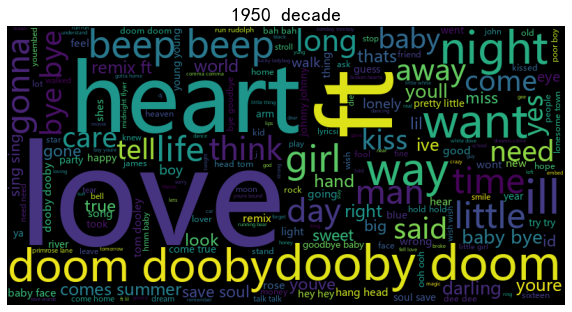

In [36]:
plt.figure( figsize=(10,8) )
plt.imshow(fig_dict['1950'])
plt.axis("off")
plt.title("1950 decade", size=20)
plt.savefig('1950.png')

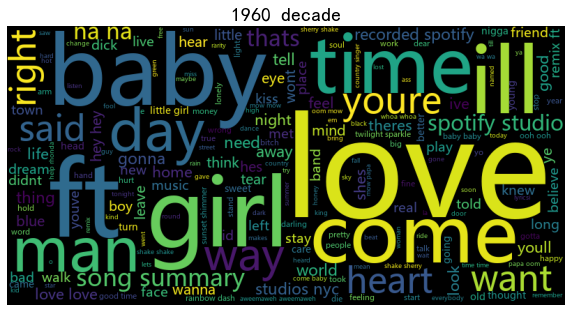

In [37]:
plt.figure( figsize=(10,8) )
plt.imshow(fig_dict['1960'])
plt.axis("off")
plt.title("1960 decade", size=20)
plt.savefig('1960.png')

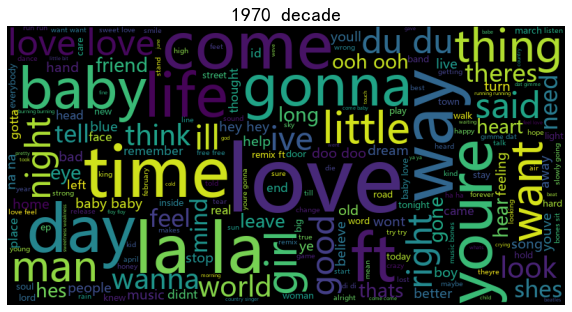

In [38]:
plt.figure( figsize=(10,8) )
plt.imshow(fig_dict['1970'])
plt.axis("off")
plt.title("1970 decade", size=20)

plt.savefig('1970.png')

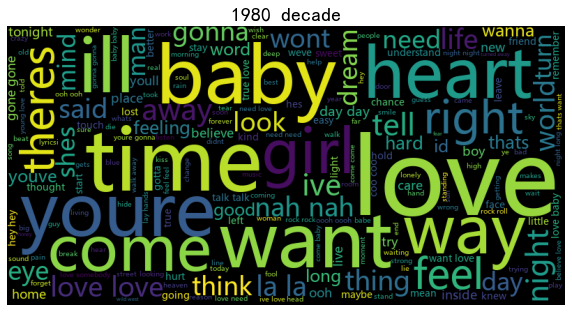

In [39]:
plt.figure( figsize=(10,8) )
plt.imshow(fig_dict['1980'])
plt.axis("off")
plt.title("1980 decade", size=20)

plt.savefig('1980.png')

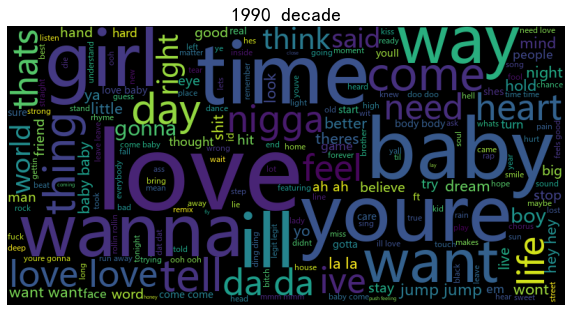

In [40]:
plt.figure( figsize=(10,8) )
plt.imshow(fig_dict['1990'])
plt.axis("off")
plt.title("1990 decade", size=20)

plt.savefig('1990.png')

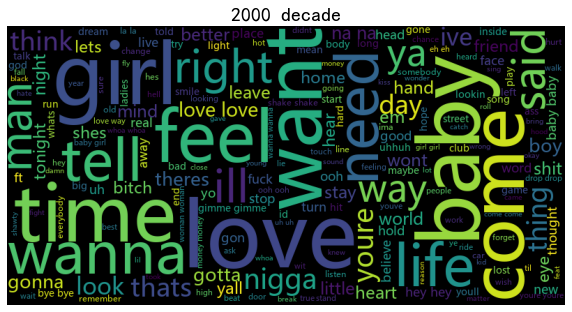

In [41]:
plt.figure( figsize=(10,8) )
plt.imshow(fig_dict['2000'])
plt.axis("off")
plt.title("2000 decade", size=20)

plt.savefig('2000.png')

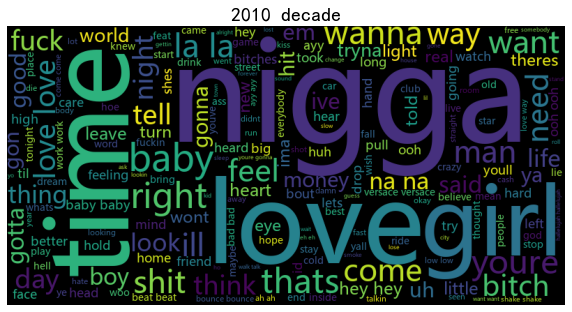

In [42]:
plt.figure( figsize=(10,8) )
plt.imshow(fig_dict['2010'])
plt.axis("off")
plt.title("2010 decade", size=20)

plt.savefig('2010.png')

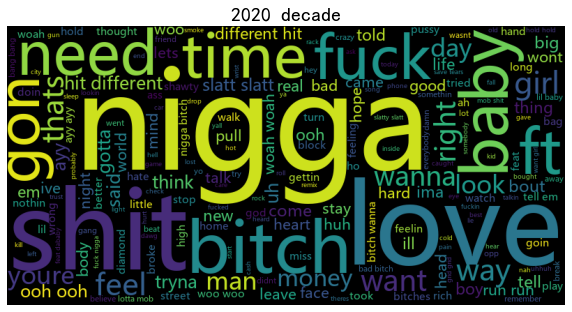

In [43]:
plt.figure( figsize=(10,8) )
plt.imshow(fig_dict['2020'])
plt.axis("off")
plt.title("2020 decade", size=20)

plt.savefig('2020.png')